Import all the needed library

In [2]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import shutil
from pathlib import Path
import pandas as pd
import numpy as np
import cv2, os, shutil, math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import glob
import tensorflow as tf

Loading Dataset

In [3]:

zip_path = '/content/archive (2).zip'
extract_path = '/content/extracted_folder'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
dataset_dir = pathlib.Path(extract_path)


In [5]:
class_names = []
for x in os.walk(dataset_dir):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 4:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

print(class_names)

['gray light', 'healthy', 'brown blight', 'Anthracnose', 'red leaf spot', 'algal leaf', 'bird eye spot', 'white spot']


In [6]:
data_dir = Path("/content/extracted_folder/tea sickness dataset")

In [7]:
for class_i in class_names:
    image_count = len(list(data_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class gray light: 100
Images in class healthy: 74
Images in class brown blight: 113
Images in class Anthracnose: 100
Images in class red leaf spot: 143
Images in class algal leaf: 113
Images in class bird eye spot: 100
Images in class white spot: 142


Data Pre-Processing

In [8]:
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       shuffle=True,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 885 files belonging to 1 classes.
Using 708 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )

Found 885 files belonging to 1 classes.
Using 177 files for validation.


In [11]:
src = '/content/extracted_folder/tea sickness dataset'
dest = './'

for path, subdirs, files in os.walk(src):
    for name in files:
        filename = os.path.join(path, name)
        shutil.copy2(filename, dest)
import shutil, random, os
dirpath = './'
destDirectory = './test'

filenames = random.sample(os.listdir(dirpath), 9)
for fname in filenames:
    srcpath = os.path.join(dirpath, fname)
    shutil.copyfile(srcpath, destDirectory)
filenames

['UNADJUSTEDNONRAW_thumb_68.jpg',
 'UNADJUSTEDNONRAW_thumb_1da.jpg',
 'UNADJUSTEDNONRAW_thumb_5a.jpg',
 'UNADJUSTEDNONRAW_thumb_186.jpg',
 'IMG_20220503_142609.jpg',
 'UNADJUSTEDNONRAW_thumb_126.jpg',
 'IMG_20220503_143709.jpg',
 'UNADJUSTEDNONRAW_thumb_23b.jpg',
 'UNADJUSTEDNONRAW_thumb_ff.jpg']

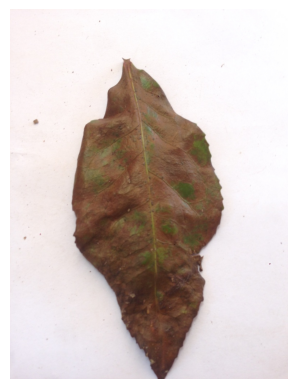

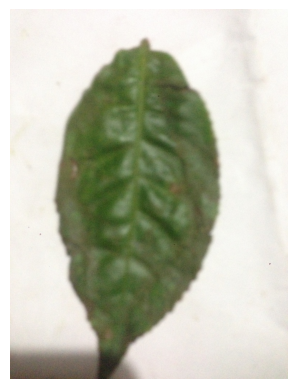

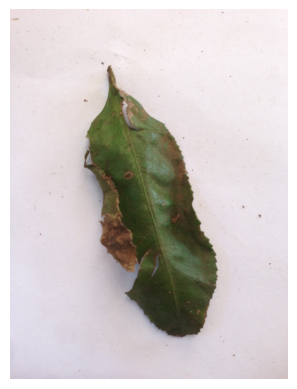

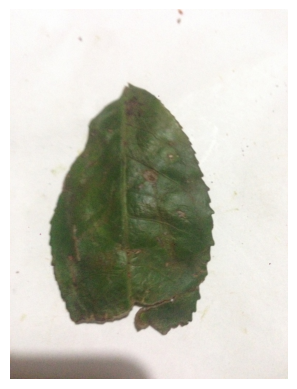

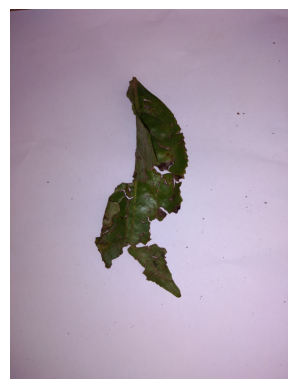

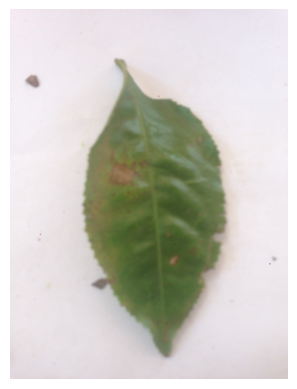

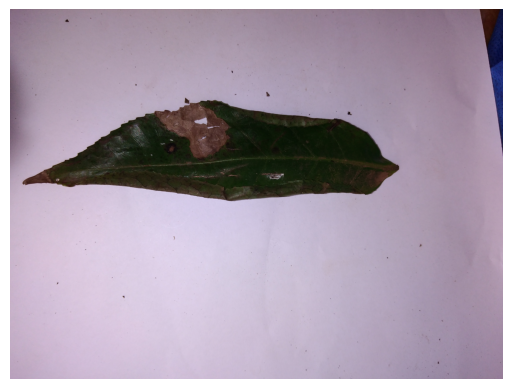

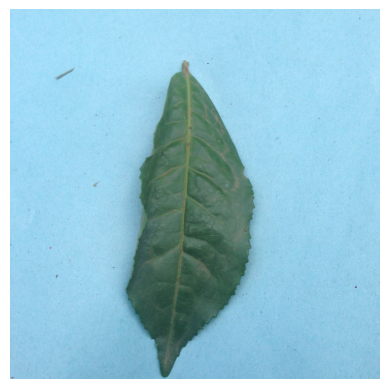

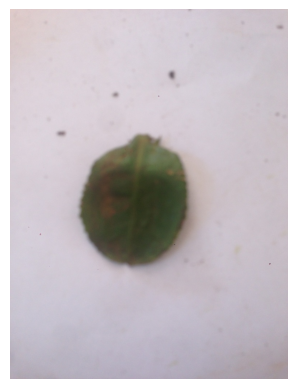

In [12]:
for a in filenames:
    img = mpimg.imread('./{}'.format(a))
    imgplot = plt.imshow(img)
    plt.axis('off')
    plt.show()
    img = Image.open('./{}'.format(a))
    img = img.resize((160, 160), Image.Resampling.LANCZOS)

In [13]:
sdir = '/content/extracted_folder/tea sickness dataset'

In [14]:
def make_dataframes(sdir):
    bad_images = []
    good_ext = ['jpg', 'jpeg', 'png', 'tiff']
    filepaths = []
    labels = []
    classes = sorted(os.listdir(sdir))
    for klass in classes:
        classpath = os.path.join(sdir, klass)
        flist = sorted(os.listdir(classpath))
        desc = f'{klass:23s}'
        for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
            fpath = os.path.join(classpath, f)
            fl = f.lower()
            index = fl.rfind('.')
            ext = fl[index + 1:]
            if ext in good_ext:
                try:
                    img = cv2.imread(fpath)
                    shape = img.shape
                    filepaths.append(fpath)
                    labels.append(klass)
                except:
                    bad_images.append(fpath)
                    print('defective image file: ', fpath)

            else:
                bad_images.append(fpath)

    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    train_df, dummy_df = train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels'])
    valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123,
                                         stratify=dummy_df['labels'])
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)
    sample_df = train_df.sample(n=50, replace=False)

    ht = 0
    wt = 0
    count = 0
    for i in range(len(sample_df)):
        fpath = sample_df['filepaths'].iloc[i]
        try:
            img = cv2.imread(fpath)
            h = img.shape[0]
            w = img.shape[1]
            wt += w
            ht += h
            count += 1
        except:
            pass
    have = int(ht / count)
    wave = int(wt / count)
    aspect_ratio = have / wave
    print('number of classes in processed dataset= ', class_count)
    counts = list(train_df['labels'].value_counts())
    print('the maximum files in any class in train_df is ', max(counts),
          '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)
    return train_df, test_df, valid_df, classes, class_count




In [15]:
train_df, test_df, valid_df, classes, class_count = make_dataframes(sdir)

white spot             : 100%|███████████████████████████████████████████| 142/142 [00:00<00:00, 341.15file/s]


number of classes in processed dataset=  8
the maximum files in any class in train_df is  114   the minimum files in any class in train_df is  59
train_df length:  708   test_df length:  89   valid_df length:  88
average image height=  2112   average image width=  1880  aspect ratio h/w=  1.123404255319149


In [16]:
n=200
batch_size = 32
working_dir=r'./'
img_size=(224,224)
epochs = 50
input_shape = (224,224, 3)

In [17]:
def balance(df, n,working_dir,img_size):
    df = df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir = os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in df['labels'].unique():
        dir_path = os.path.join(aug_dir, label)
        os.mkdir(dir_path)
    total = 0
    gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, zoom_range=0.2)
    groups = df.groupby('labels')
    for label in df['labels'].unique():
        group = groups.get_group(label)
        sample_count = len(group)
        if sample_count < n:
            aug_img_count = 0
            delta = n - sample_count
            target_dir = os.path.join(aug_dir, label)
            msg = '{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='')  # prints over on the same line
            aug_gen = gen.flow_from_dataframe(group, x_col='filepaths', y_col=None, target_size=img_size,
                                              class_mode=None, batch_size=batch_size, shuffle=False,
                                              save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                              save_format='jpg')
            while aug_img_count < delta:
                images = next(aug_gen)
                aug_img_count += len(images)
            total += aug_img_count
    print('Total Augmented images created= ', total)
    aug_fpaths, aug_labels = [], []
    classlist = os.listdir(aug_dir)
    for target in classlist:
        classpath = os.path.join(aug_dir, target)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            aug_fpaths.append(fpath)
            aug_labels.append(target)
    Fseries = pd.Series(aug_fpaths, name='filepaths')
    Lseries = pd.Series(aug_labels, name='labels')
    aug_df = pd.concat([Fseries, Lseries], axis=1)
    df = pd.concat([df, aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is ', len(df))
    return df



In [18]:
train_df = balance(train_df, n, working_dir, img_size)

Initial length of dataframe is  708
Found 114 validated image filenames.
Found 59 validated image filenames.
Found 80 validated image filenames.
Found 80 validated image filenames.
Found 91 validated image filenames.
Found 114 validated image filenames.
Found 90 validated image filenames.
Found 80 validated image filenames.
Total Augmented images created=  1019
Length of augmented dataframe is  1727


In [19]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen = ImageDataGenerator(horizontal_flip=True)
    t_and_v_gen = ImageDataGenerator()
    msg = '{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='')
    train_ds = trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=True)

    msg = '{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='')
    valid_ds = t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', batch_size=batch_size, shuffle=False)

    test_len = len(test_df)
    test_batch_size = sorted([int(test_len / n) for n in range(1, test_len + 1)
                              if test_len % n == 0 and test_len / n<=80], reverse=True)[0]
    test_steps = int(test_len / test_batch_size)
    msg = '{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='')
    test_ds = t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                               target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', batch_size=batch_size, shuffle=False)

    classes = list(train_ds.class_indices.keys())
    class_count = len(classes)
    print('test batch size: ', test_batch_size, 'test steps: ', test_steps, 'number of classes : ', class_count)

    return train_ds, test_ds, valid_ds



In [20]:
train_ds, test_ds, valid_ds = make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 1727 validated image filenames belonging to 8 classes.
Found 88 validated image filenames belonging to 8 classes.
Found 89 validated image filenames belonging to 8 classes.
test batch size:  1 test steps:  89 number of classes :  8


Feature Extraction

In [21]:
class_mapping = train_ds.class_indices
print(class_mapping)

{'Anthracnose': 0, 'algal leaf': 1, 'bird eye spot': 2, 'brown blight': 3, 'gray light': 4, 'healthy': 5, 'red leaf spot': 6, 'white spot': 7}


In [22]:
class_mapping = {
    'Anthracnose': 0,
    'algal leaf': 1,
    'bird eye spot': 2,
    'brown blight': 3,
    'gray light': 4,
    'healthy': 5,
    'red leaf spot': 6,
    'white spot': 7
}

In [23]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:


def extract_features(generator, feature_extractor):
    features = []
    labels = []
    for batch_x, batch_y in generator:
        batch_x = tf.cast(batch_x, tf.float32) / 255.0 #normalize the batch to [0,1]
        batch_features = feature_extractor.predict(batch_x)
        features.append(batch_features)
        labels.append(batch_y)



        if len(features) * generator.batch_size >= generator.samples:
            break


    return np.vstack(features), np.vstack(labels)


In [25]:
train_features, train_labels = extract_features(train_ds, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

In [26]:



def enhanced_visualize_features(features, labels, method='PCA', class_mapping=None):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Unsupported method. Choose 'PCA' or 't-SNE'.")


    reduced_features = reducer.fit_transform(features)
    label_indices = np.argmax(labels, axis=1)  # Convert one-hot to class indices


    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=label_indices,
        cmap='tab10',
        alpha=0.9,
        s=80
    )


    colorbar = plt.colorbar(scatter, label="Class Index")
    colorbar.set_ticks(range(len(class_mapping)))


    if class_mapping:
        class_names = {v: k for k, v in class_mapping.items()}
        handles = [
            plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=scatter.cmap(scatter.norm(i)),
                       markersize=12, label=class_names[i])
            for i in class_names.keys()
        ]
        plt.legend(
            handles=handles,
            title="Classes",
            title_fontsize=14,
            fontsize=12,
            loc='best',
            frameon=True
        )


    plt.title(f" Feature Visualization using {method}", fontsize=18)
    plt.xlabel("Component 1", fontsize=14)
    plt.ylabel("Component 2", fontsize=14)
    plt.grid(alpha=0.3)
    plt.show()




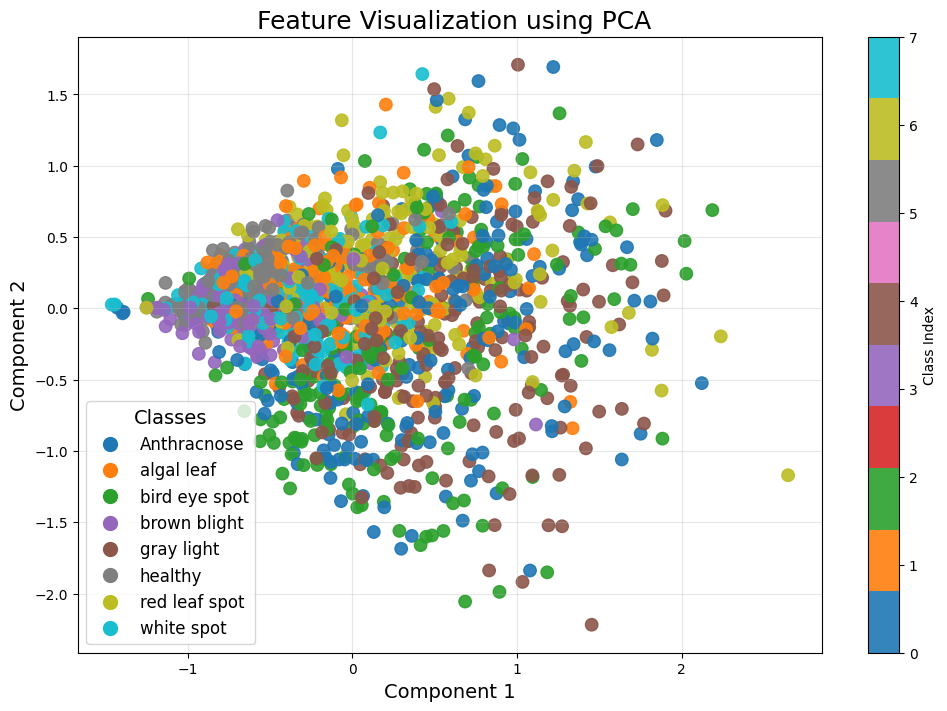

In [27]:

enhanced_visualize_features(train_features, train_labels, method='PCA', class_mapping=class_mapping)





 highlights overlapping clusters for similar classes (e.g., "Anthracnose" and "Bird Eye Spot"), indicating potential confusion due to shared patterns. Distinctive classes like "Red Leaf Spot" show better separation, suggesting strong feature representation

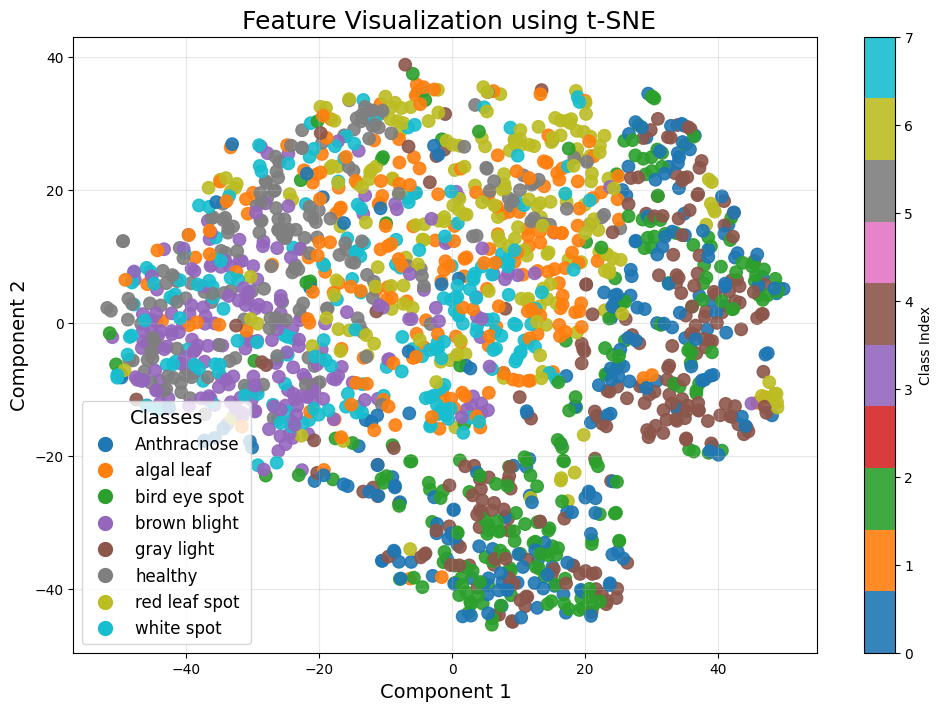

In [28]:
enhanced_visualize_features(train_features, train_labels, method='t-SNE', class_mapping=class_mapping)

shows better local grouping of features, revealing clusters for specific classes like "Red Leaf Spot" and "White Spot." However, there are still overlapping regions, indicating similarities in features for some classes, such as "Anthracnose" and "Bird Eye Spot."

In [29]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [30]:
layer_name = 'conv2_block1_1_relu'
intermediate_model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer_name).output)

In [31]:
def extract_features_with_intermediate_layer(dataset, feature_extractor):

    features = []
    labels = []

    print("Extracting features...")
    for batch in tqdm(dataset):
        batch_x, batch_y = batch
        batch_x = tf.cast(batch_x, tf.float32) / 255.0  # Normalize to [0, 1]
        batch_features = feature_extractor.predict(batch_x, verbose=0)
        features.append(batch_features)
        labels.append(batch_y.numpy())  # Convert labels to numpy for later processing

    features = np.vstack(features)  # Combine features into one array
    labels = np.concatenate(labels)  # Combine labels into one array
    return features, labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


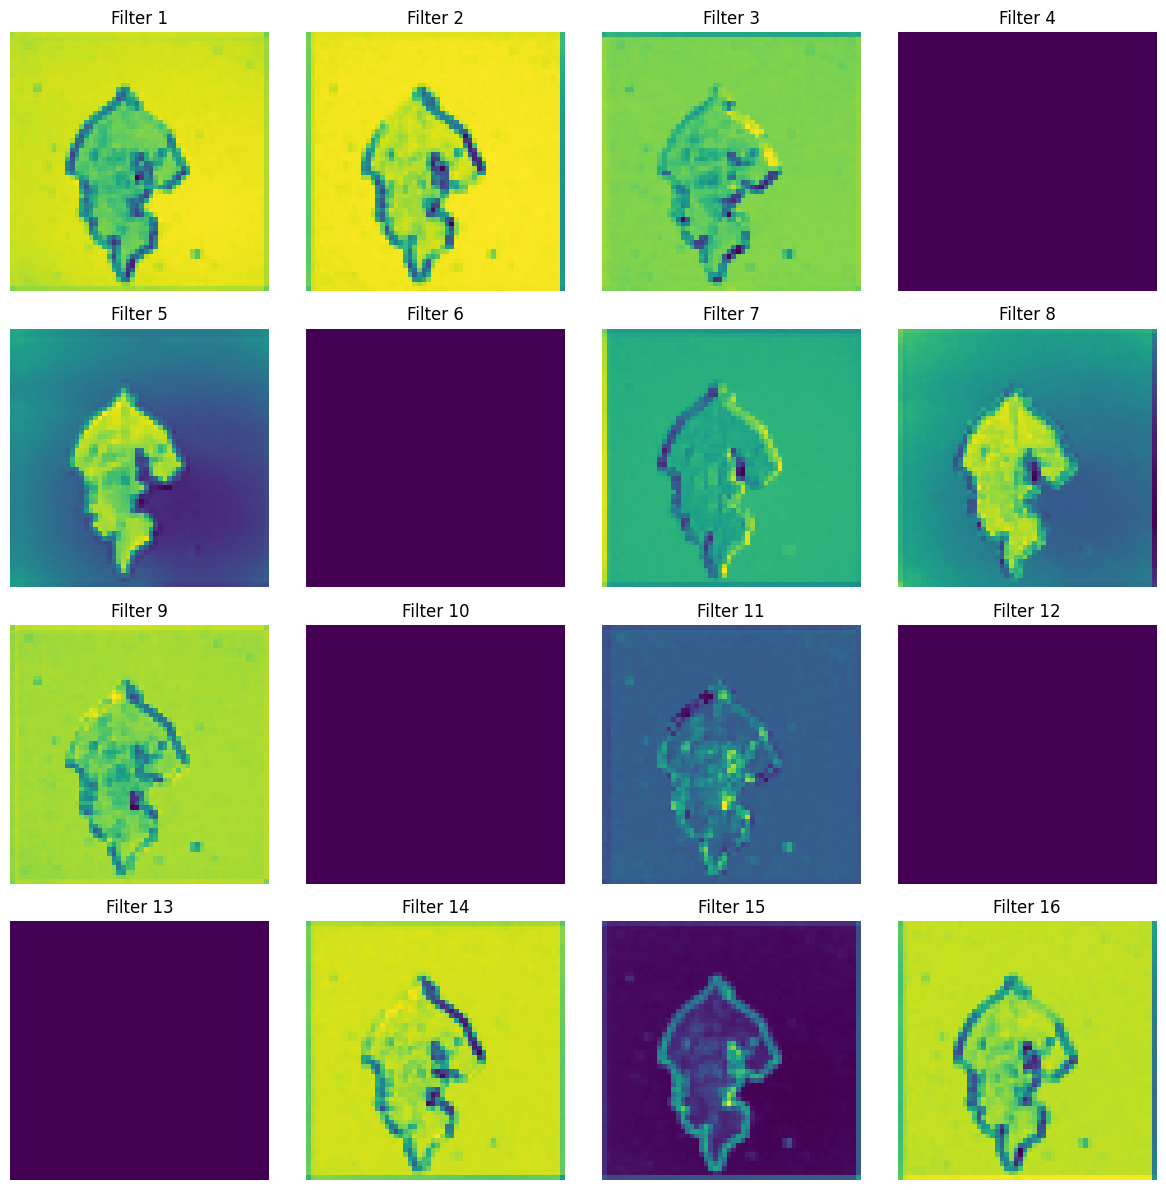

In [32]:


def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

sample_image_path = "/content/IMG_20220503_135331.jpg"
processed_image = preprocess_image(sample_image_path)

feature_map = intermediate_model.predict(processed_image)
feature_map = np.squeeze(feature_map)

def plot_feature_map(feature_map, num_filters=16):
    num_filters = min(num_filters, feature_map.shape[-1])
    grid_size = int(np.ceil(np.sqrt(num_filters)))
    plt.figure(figsize=(12, 12))
    for i in range(num_filters):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(feature_map[:, :, i], cmap='viridis')
        plt.axis('off')
        plt.title(f"Filter {i+1}")
    plt.tight_layout()
    plt.show()

plot_feature_map(feature_map, num_filters=16)


 Each filter highlights specific patterns or regions of interest, such as edges, textures, or shapes, contributing to the model's understanding of the image. The diversity of the activations indicates the model's ability to detect varied features across spatial regions.

Implementing Resnet-50 on the dataset

In [33]:


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Reduce feature maps to a vector
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),  # Fully connected layer
    Dropout(0.5),  # Dropout for regularization
    Dense(len(class_mapping), activation='softmax')  # Output layer (num_classes)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 23,797,896 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [34]:

img_height = 224
img_width = 224

# Update dataset creation
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=val_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=val_split,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=val_batch
)

Found 885 files belonging to 1 classes.
Using 708 files for training.
Found 885 files belonging to 1 classes.
Using 177 files for validation.


In [35]:
# Path to the dataset directory
source_dir = '/content/extracted_folder/tea sickness dataset'
dest_dir = '/content/reorganized_dataset'

# Ensure destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Move images into subdirectories based on class_mapping
for class_name, class_idx in class_mapping.items():
    class_dir = os.path.join(dest_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Find and move images for this class
    for img_file in os.listdir(source_dir):
        if img_file.startswith(class_name):  # Assuming class names are part of filenames
            shutil.move(os.path.join(source_dir, img_file), os.path.join(class_dir, img_file))

print("Dataset reorganized into subdirectories.")


Dataset reorganized into subdirectories.


In [36]:
dataset_dir = '/content/reorganized_dataset'

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

print(f"Found {len(train_ds.class_names)} classes:", train_ds.class_names)

Found 885 files belonging to 8 classes.
Using 708 files for training.
Found 885 files belonging to 8 classes.
Using 177 files for validation.
Found 8 classes: ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.2630 - loss: 4.6311 - val_accuracy: 0.7175 - val_loss: 2.7041
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 0.5973 - loss: 2.7416 - val_accuracy: 0.6441 - val_loss: 2.2182
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 186s 6s/step - accuracy: 0.6639 - loss: 2.1756 - val_accuracy: 0.7684 - val_loss: 1.8283
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 159s 7s/step - accuracy: 0.7315 - loss: 1.8584 - val_accuracy: 0.7571 - val_loss: 1.6505
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step - accuracy: 0.7792 - loss: 1.5945 - val_accuracy: 0.7740 - val_loss: 1.5209
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.7960 - loss: 1.4586 - val_accuracy: 0.8249 - val_loss: 1.3313
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 202s 6s/step - accuracy: 0.8000 - loss: 1.2950 - val_accuracy: 0.8136 - val_loss: 1.2696
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 189s 6s/step - accuracy: 0.8010 - loss: 1.2053 - val_accuracy: 0.8531 - v

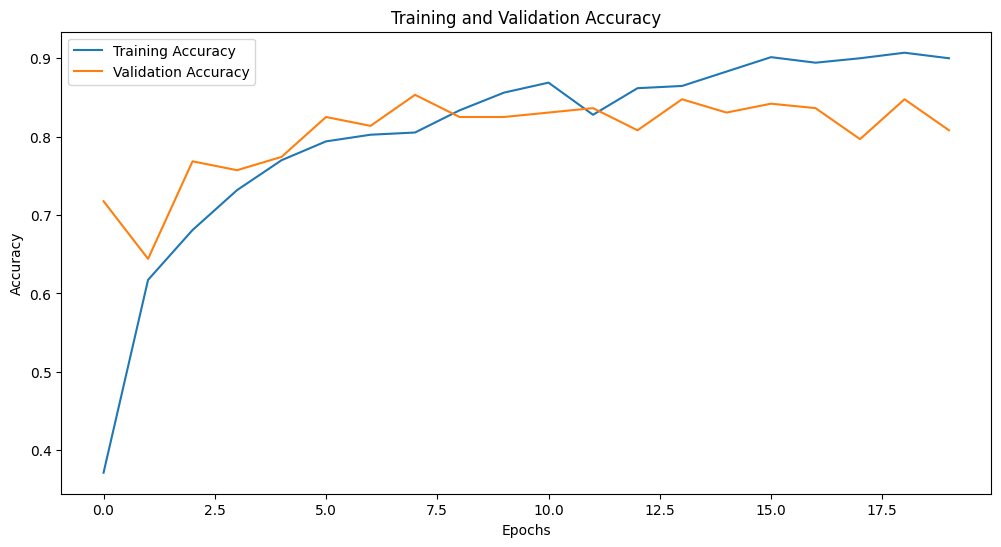

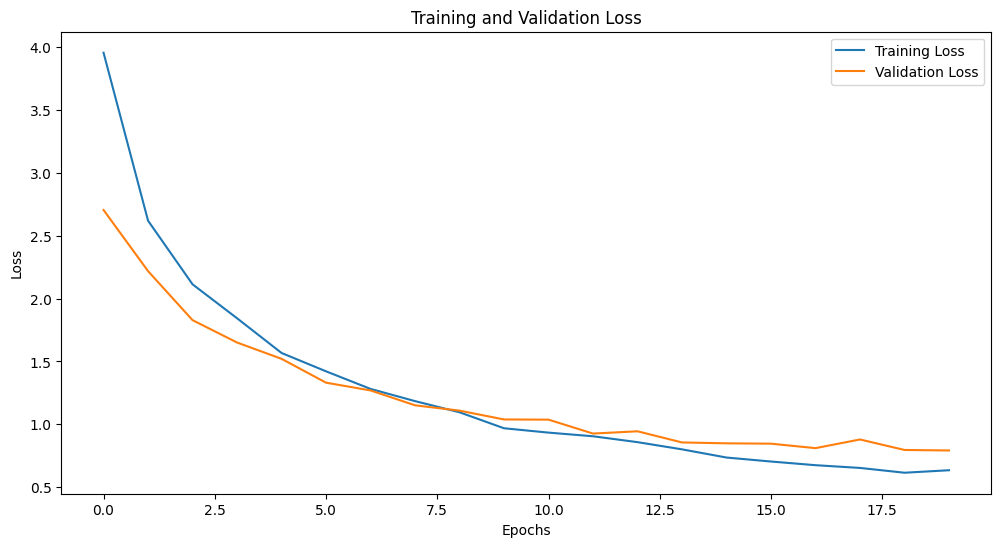

In [37]:


# Load ResNet-50 pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to use it as a feature extractor
base_model.trainable = False

# Add custom classification layers on top of ResNet-50
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu',kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(8, activation='softmax')  # 8 classes in your dataset
])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True
)
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


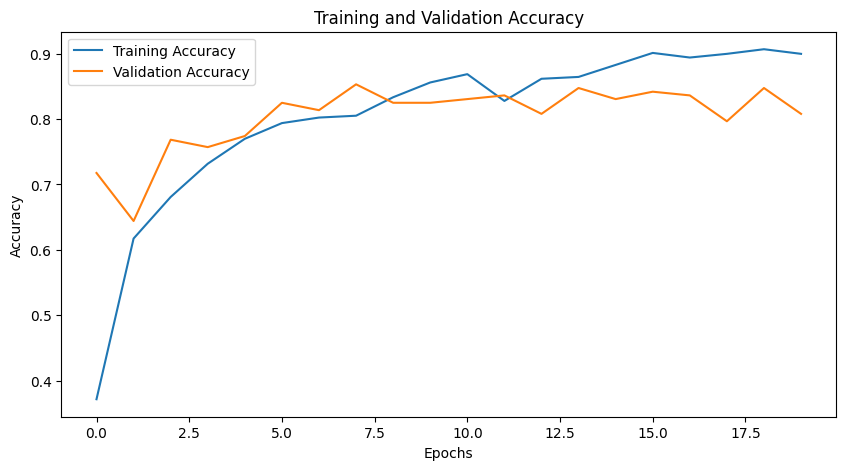

In [38]:


# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step


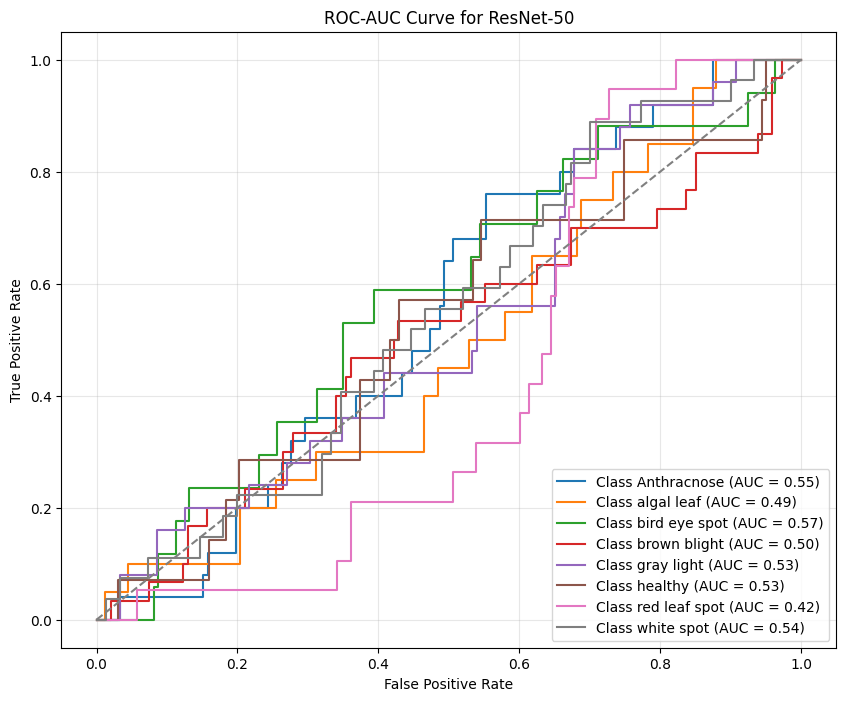

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the true labels for multi-class ROC computation
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)
y_pred_probs = model.predict(val_ds)

# Binarize the labels to calculate ROC curves for each class
y_true_bin = label_binarize(y_true, classes=range(len(class_mapping)))
n_classes = len(class_mapping)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(
        fpr[i], tpr[i],
        label=f"Class {list(class_mapping.keys())[i]} (AUC = {roc_auc[i]:.2f})"
    )

# Plot diagonal for random chance
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

plt.title("ROC-AUC Curve for ResNet-50")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


Ml implementation on this code

In [41]:
X, y = train_features, np.argmax(train_labels, axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}

In [44]:
results = {}


Training Logistic Regression...
Accuracy: 0.5520
               precision    recall  f1-score   support

  Anthracnose       0.40      0.29      0.34        48
   algal leaf       0.45      0.51      0.48        37
bird eye spot       0.41      0.38      0.40        45
 brown blight       0.65      0.68      0.67        47
   gray light       0.69      0.71      0.70        58
      healthy       0.70      0.85      0.77        41
red leaf spot       0.55      0.55      0.55        38
   white spot       0.38      0.38      0.38        32

     accuracy                           0.55       346
    macro avg       0.53      0.54      0.53       346
 weighted avg       0.54      0.55      0.54       346



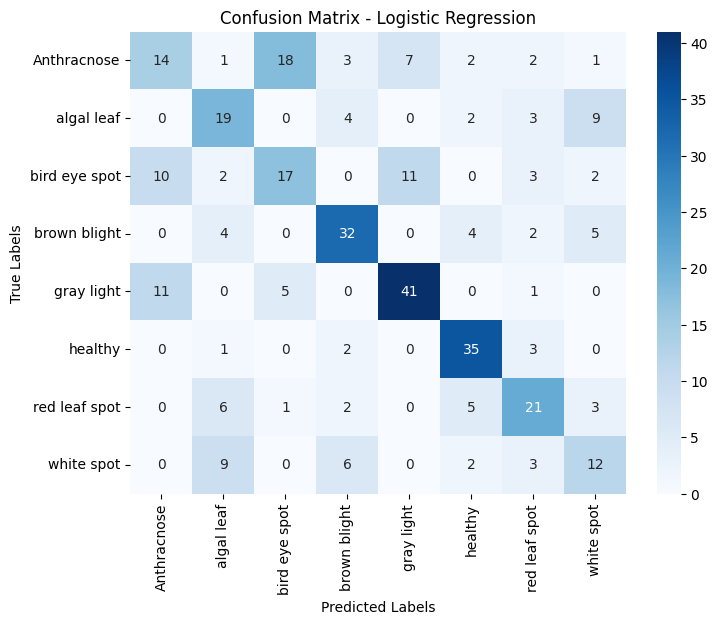


Training SVM...
Accuracy: 0.5925
               precision    recall  f1-score   support

  Anthracnose       0.40      0.35      0.37        48
   algal leaf       0.49      0.65      0.56        37
bird eye spot       0.44      0.49      0.46        45
 brown blight       0.69      0.74      0.71        47
   gray light       0.71      0.64      0.67        58
      healthy       0.88      0.88      0.88        41
red leaf spot       0.67      0.63      0.65        38
   white spot       0.42      0.31      0.36        32

     accuracy                           0.59       346
    macro avg       0.59      0.59      0.58       346
 weighted avg       0.59      0.59      0.59       346



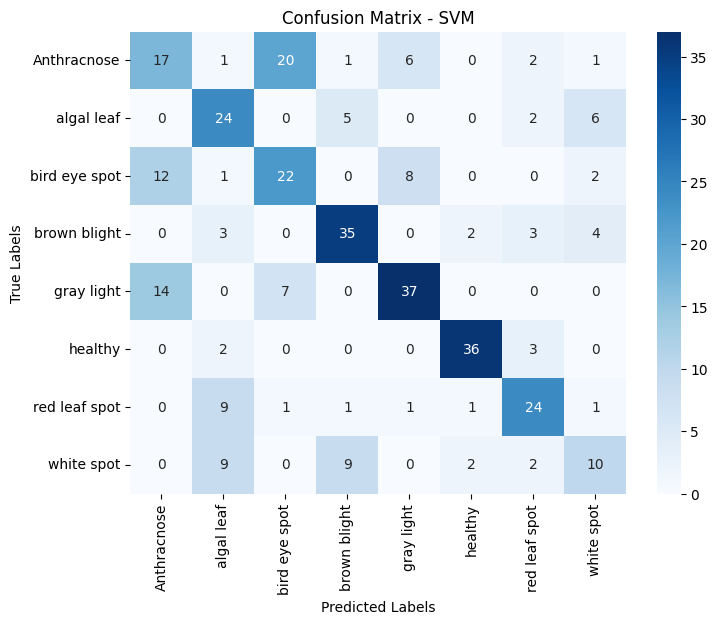


Training Random Forest...
Accuracy: 0.5405
               precision    recall  f1-score   support

  Anthracnose       0.41      0.48      0.44        48
   algal leaf       0.47      0.51      0.49        37
bird eye spot       0.48      0.47      0.47        45
 brown blight       0.65      0.64      0.65        47
   gray light       0.72      0.57      0.63        58
      healthy       0.72      0.68      0.70        41
red leaf spot       0.56      0.53      0.54        38
   white spot       0.33      0.41      0.37        32

     accuracy                           0.54       346
    macro avg       0.54      0.54      0.54       346
 weighted avg       0.56      0.54      0.55       346



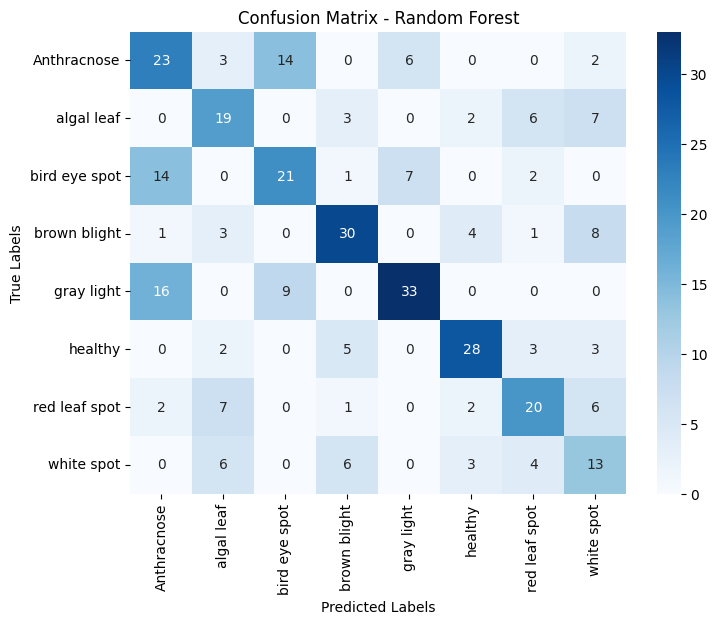


Training Gradient Boosting...
Accuracy: 0.5491
               precision    recall  f1-score   support

  Anthracnose       0.42      0.46      0.44        48
   algal leaf       0.43      0.62      0.51        37
bird eye spot       0.46      0.47      0.46        45
 brown blight       0.65      0.55      0.60        47
   gray light       0.72      0.59      0.65        58
      healthy       0.86      0.78      0.82        41
red leaf spot       0.64      0.47      0.55        38
   white spot       0.33      0.44      0.38        32

     accuracy                           0.55       346
    macro avg       0.56      0.55      0.55       346
 weighted avg       0.58      0.55      0.56       346



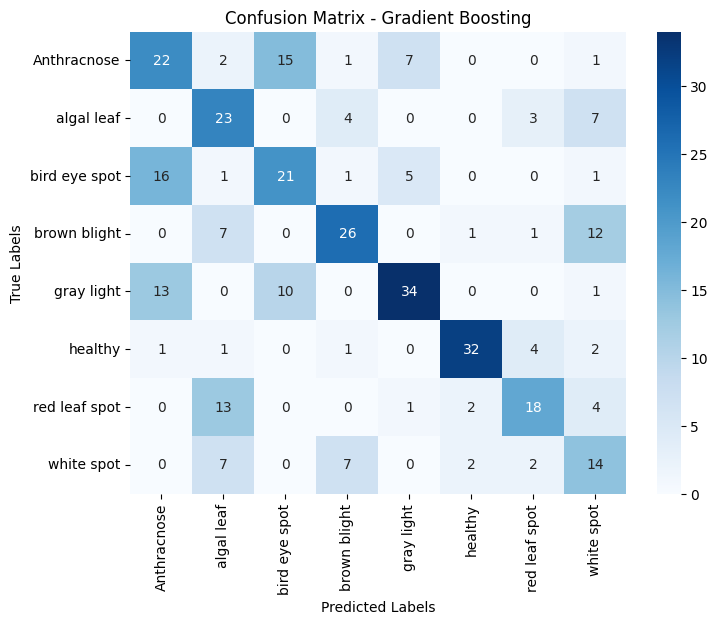


Training KNN...
Accuracy: 0.4566
               precision    recall  f1-score   support

  Anthracnose       0.35      0.48      0.41        48
   algal leaf       0.36      0.43      0.40        37
bird eye spot       0.41      0.40      0.40        45
 brown blight       0.48      0.70      0.57        47
   gray light       0.80      0.34      0.48        58
      healthy       0.56      0.46      0.51        41
red leaf spot       0.55      0.45      0.49        38
   white spot       0.35      0.38      0.36        32

     accuracy                           0.46       346
    macro avg       0.48      0.46      0.45       346
 weighted avg       0.50      0.46      0.46       346



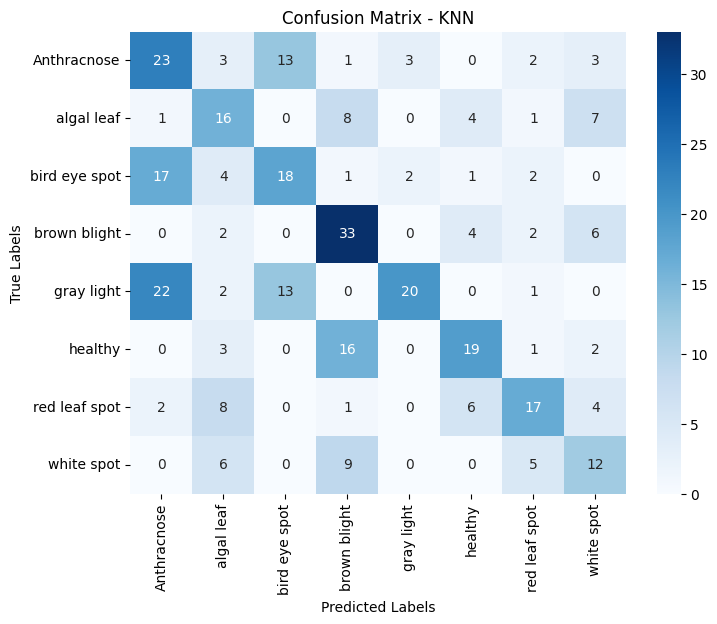


Training Naive Bayes...
Accuracy: 0.3699
               precision    recall  f1-score   support

  Anthracnose       0.16      0.10      0.13        48
   algal leaf       0.31      0.41      0.35        37
bird eye spot       0.35      0.38      0.37        45
 brown blight       0.42      0.81      0.55        47
   gray light       0.67      0.41      0.51        58
      healthy       0.34      0.24      0.29        41
red leaf spot       0.27      0.16      0.20        38
   white spot       0.32      0.41      0.36        32

     accuracy                           0.37       346
    macro avg       0.36      0.36      0.34       346
 weighted avg       0.37      0.37      0.35       346



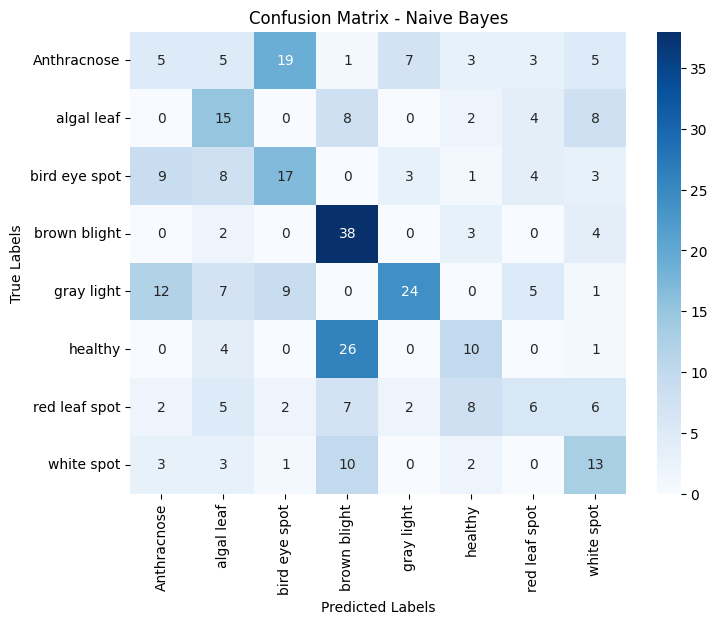


Training Decision Tree...
Accuracy: 0.4046
               precision    recall  f1-score   support

  Anthracnose       0.33      0.33      0.33        48
   algal leaf       0.38      0.41      0.39        37
bird eye spot       0.41      0.38      0.40        45
 brown blight       0.45      0.36      0.40        47
   gray light       0.54      0.53      0.54        58
      healthy       0.47      0.56      0.51        41
red leaf spot       0.36      0.34      0.35        38
   white spot       0.21      0.25      0.23        32

     accuracy                           0.40       346
    macro avg       0.40      0.40      0.39       346
 weighted avg       0.41      0.40      0.40       346



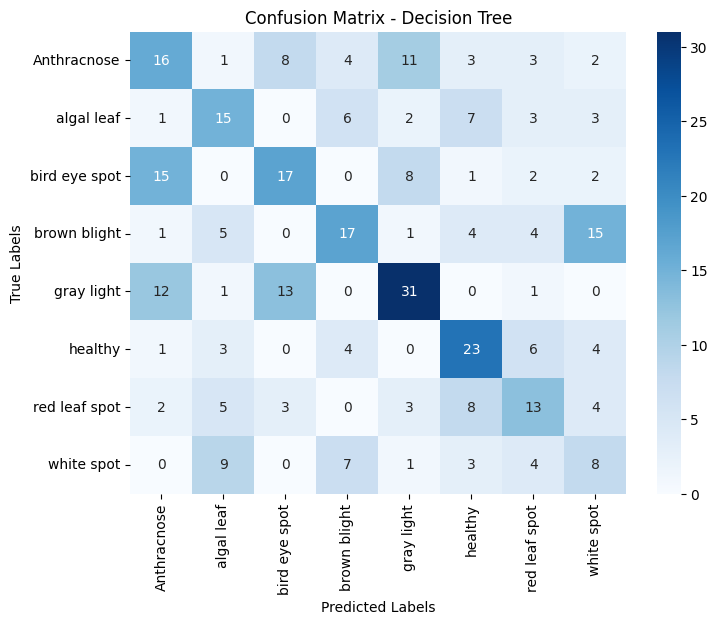

Logistic Regression: Accuracy = 0.5520
SVM: Accuracy = 0.5925
Random Forest: Accuracy = 0.5405
Gradient Boosting: Accuracy = 0.5491
KNN: Accuracy = 0.4566
Naive Bayes: Accuracy = 0.3699
Decision Tree: Accuracy = 0.4046


In [45]:
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate performance
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=class_mapping.keys()))

    # Store results for comparison
    results[name] = {
        "accuracy": acc,
        "classification_report": classification_report(y_test, y_pred, target_names=class_mapping.keys(), output_dict=True)
    }

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Summary of Results
for model_name, metrics in results.items():
    print(f"{model_name}: Accuracy = {metrics['accuracy']:.4f}")